# Solving Boolean Satisfiability Problems using Grover's Algorithm

## 1. Introduction

The Boolean satisfiability problem, often referred to as SAT, is about finding a solution to a logical expression. The expression is built using variables, logical operators (like AND, OR, NOT), and it evaluates to either TRUE or FALSE. The goal is to determine if there is any combination of true and false values assigned to the variables that makes the entire expression true. If such a combination exists, the expression is satisfiable; otherwise, it is unsatisfiable. In summary, SAT is the quest to figure out if a logical statement can ever be true based on different assignments of true and false values to its variables.

In this section, we will look at solving a specific Boolean satisfiability problem (3-Satisfiability) using Grover’s algorithm, with the aforementioned run time of $O(\sqrt{N})$

## 2. 3-Satisfiability Problem 

 Let us consider a Boolean function $f$ with three Boolean variables $v_1,v_2,v_3$ as below:



$$f(v_1,v_2,v_3) = (\neg v_1 \vee \neg v_2 \vee \neg v_3) \wedge (v_1 \vee \neg v_2 \vee v_3) \wedge (v_1 \vee v_2 \vee \neg v_3) \wedge (v_1 \vee \neg v_2 \vee \neg v_3) \wedge (\neg v_1 \vee  v_2 \vee v_3)\wedge (\neg v_1 \vee \neg v_2 \vee v_3)$$
First we need to understand the input DIMACS CNF format that Qiskit Aqua uses for such problem, which looks like the following for the problem:
~~~
c example DIMACS CNF 3-SAT
p cnf 3 6
-1 -2 -3 0
1 -2 3 0
1 2 -3 0
1 -2 -3 0
-1 2 3 0
-1 -2 3 0
~~~
- Lines that start with `c` are comments
    - eg. `c example DIMACS CNF 3-SAT`
- The first non-comment line needs to be of the form `p cnf nbvar nbclauses`, where
  - `cnf` indicates that the input is in CNF format
  - `nbvar` is the exact number of variables appearing in the file
  - `nbclauses` is the exact number of clauses contained in the file
  - eg. `p cnf 3 6`
- Then there is a line for each clause, where 
  - each clause is a sequence of distinct non-null numbers between `-nbvar` and `nbvar` ending with `0` on the same line
  - positive numbers denote the corresponding variables
  - negative numbers denote the negations of the corresponding variables
  - eg. `-1 2 3 0` corresponds to the clause $\neg v_1 \vee v_2 \vee v_3$
  


Now moving to the coading part, we will create oracle for Grover's algorithm.we use the LogicalExpressionOracle component provided by Qiskit which will create corresponding oracle circuit. 

In [85]:
# Importing required libraries
import numpy as np
import pylab
import qiskit_algorithms
import tweedledum
from qiskit import assemble
from qiskit.visualization import plot_histogram
from qiskit import Aer, transpile
from qiskit.utils import QuantumInstance
from qiskit.algorithms import Grover, AmplificationProblem
from qiskit.circuit.library import PhaseOracle
import qiskit.tools.jupyter

We have a DIMACS file saved to the relative path `C:\Users\VARNIT GUPTA\Desktop\Quantum Random Walks\c example DIMACS-CNF 3-SAT.dimacs.txt` which looks as follows:

In [86]:
with open(r'C:\Users\VARNIT GUPTA\Desktop\Quantum Random Walks\c example DIMACS-CNF 3-SAT.dimacs.txt', 'r') as f:
    dimacs = f.read()
print(dimacs)

c example DIMACS-CNF 3-SAT
p cnf 3 6
-1 -2 -3 0
1 -2 3 0
1 2 -3 0
1 -2 -3 0
-1 2 3 0
-1 -2 3 0


In order to create oracle circuit from the file we can use `PhaseOracle`

In [87]:
oracle = PhaseOracle.from_dimacs_file(r'C:\Users\VARNIT GUPTA\Desktop\Quantum Random Walks\c example DIMACS-CNF 3-SAT.dimacs.txt')
oracle.draw()

q_0: ──────────■──
               │  
q_1: ──────o───o──
     ┌───┐ │ ┌───┐
q_2: ┤ X ├─■─┤ X ├
     └───┘   └───┘

Now, we have to define a function to check either the oracle is producing correct answer or not. The function will return `True` if it's a correct solution, or `False` otherwise.

In [1]:
class Verifier():
    
    def __init__(self, dimacs_file):
        with open(dimacs_file, 'r') as f:
            self.dimacs = f.read()

    def is_correct(self, guess):
        
        # Convert characters to bools & reverse
        guess = [bool(int(x)) for x in guess][::-1]
        for line in self.dimacs.split('\n'):
            line = line.strip(' 0')
            clause_eval = False
            for literal in line.split(' '):
                if literal in ['p', 'c']:
                    # line is not a clause
                    clause_eval = True
                    break
                if '-' in literal:
                    literal = literal.strip('-')
                    lit_eval = not guess[int(literal)-1]
                else:
                    lit_eval = guess[int(literal)-1]
                clause_eval |= lit_eval
            if clause_eval is False:
                return False
        return True

In [89]:
v = Verifier(r'C:\Users\VARNIT GUPTA\Desktop\Quantum Random Walks\c example DIMACS-CNF 3-SAT.dimacs.txt')   
v.is_correct('001')

False

In [90]:
# Configure backend
backend = Aer.get_backend('aer_simulator')
quantum_instance = QuantumInstance(backend, shots=1024)

# Create a new problem from the phase oracle and the
# verification function
problem = AmplificationProblem(oracle=oracle, is_good_state=v.is_correct)

# Use Grover's algorithm to solve the problem
grover = Grover(quantum_instance=quantum_instance)
result = grover.amplify(problem)
result.top_measurement

C:\Users\VARNIT GUPTA\AppData\Local\Temp\ipykernel_19076\2289216011.py:3: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend, shots=1024)
C:\Users\VARNIT GUPTA\AppData\Local\Temp\ipykernel_19076\2289216011.py:10: DeprecationWarning: ``qiskit.algorithms.amplitude_amplifiers.grover.Grover.__init__()``'s argument ``quantum_instance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the ``sampler`` argument. See https://qisk.it/algo_migration for a migration guide.
  grover = Grover(quantum_instance=quantum_instance)


'101'

Solution shown above is the most optimal solution as suggested by our model.
To show complete measurement result we plot a histogram. It can be seen that the binary strings `000` and `101` corresponding to the three satisfying solutions all have high probabilities associated with them.

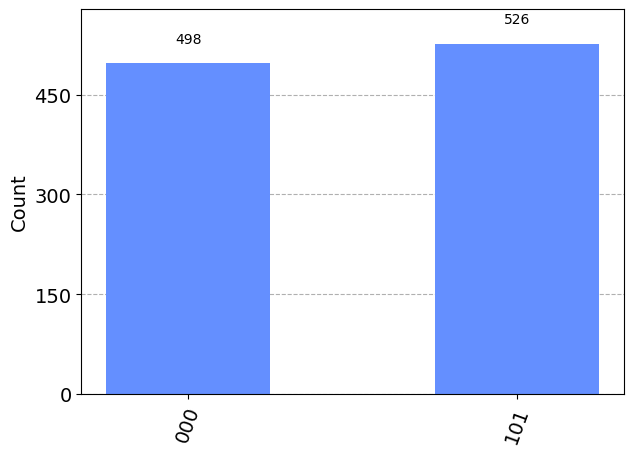

In [91]:
plot_histogram(result.circuit_results)